In [1]:
# libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pingouin as pg
import scipy.stats as st

import warnings

warnings.filterwarnings(action='ignore')

In [2]:
# загрузка данных
df = pd.read_csv('kicksharing.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396749 entries, 0 to 396748
Data columns (total 20 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   order_rk                 396749 non-null  int64  
 1   party_rk                 396749 non-null  int64  
 2   gender_cd                393828 non-null  object 
 3   age                      396749 non-null  int64  
 4   education_level_cd       190059 non-null  object 
 5   marital_status_cd        217729 non-null  object 
 6   lvn_state_nm             362572 non-null  object 
 7   minute_cost              396749 non-null  float64
 8   activation_cost          396749 non-null  float64
 9   hold_amount              396749 non-null  float64
 10  transport_model          396749 non-null  object 
 11  distance_km              396749 non-null  float64
 12  created_dttm             396749 non-null  object 
 13  book_start_dttm          396749 non-null  object 
 14  book

In [3]:
print('Размер датафрейма', df.shape)
row_cnt = df.shape[0]
df.head(2)

Размер датафрейма (396749, 20)


,order_rk,party_rk,gender_cd,age,education_level_cd,marital_status_cd,lvn_state_nm,minute_cost,activation_cost,hold_amount,transport_model,distance_km,created_dttm,book_start_dttm,book_end_dttm,book_time_zone_cd,local_book_start_dttm,nominal_price_rub_amt,loyalty_accrual_rub_amt,loyalty_accrual_bns_amt
0,266071307,761067705,M,40,UGR,DIV,ТЮМЕНСКАЯ ОБЛ,4.99,30.0,300.0,SL,3.690479,2024-08-07 09:47:25.000000,2024-08-07 09:47:29.325252,2024-08-07 10:07:59.339524,5,2024-08-07 11:47:29.325252,134.79,19.48,NaN
1,355113920,614049469,F,30,GRD,MAR,РОСТОВСКАЯ ОБЛ,8.49,50.0,300.0,SL,1.114912,2024-10-17 14:57:20.000000,2024-10-17 14:57:24.586000,2024-10-17 15:04:19.419607,3,2024-10-17 14:57:24.586000,109.43,40.30,NaN


In [4]:
# перевод дат
df['created_dttm'] = pd.to_datetime(df['created_dttm'])
df['book_start_dttm'] = pd.to_datetime(df['book_start_dttm'])
df['book_end_dttm'] = pd.to_datetime(df['book_end_dttm'])
df.iloc[:, 12:15].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396749 entries, 0 to 396748
Data columns (total 3 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   created_dttm     396749 non-null  datetime64[ns]
 1   book_start_dttm  396749 non-null  datetime64[ns]
 2   book_end_dttm    396749 non-null  datetime64[ns]
dtypes: datetime64[ns](3)
memory usage: 9.1 MB


In [5]:
df['created_dttm'].min(),df['created_dttm'].max() 

(Timestamp('2024-04-07 14:56:47'), Timestamp('2024-10-21 17:18:04'))

### дубли, пропуски

In [6]:
# выявление дубликатов,пропусков

#дубли
print('Дубликатов нет'if df.duplicated().sum() == 0 else 'Дубликаты есть')

# пропуски
df.isna().sum()\
    .reset_index()\
    .rename(columns={'index': 'col_name', 0: 'isna_cnt'})\
    .query('isna_cnt != 0')\
    .sort_values('isna_cnt', ascending=False)\
    .assign(isna_normalize=lambda x: x['isna_cnt'] / row_cnt)

Дубликатов нет


,col_name,isna_cnt,isna_normalize
19,loyalty_accrual_bns_amt,374801,0.944680
4,education_level_cd,206690,0.520959
5,marital_status_cd,179020,0.451217
6,lvn_state_nm,34177,0.086143
18,loyalty_accrual_rub_amt,29757,0.075002
2,gender_cd,2921,0.007362


---

### проверка на корректность данных, аномалии,выбросы

In [7]:
# проверка на корректность данных, аномалии,выбросы
df.describe()

,order_rk,party_rk,age,minute_cost,activation_cost,hold_amount,distance_km,created_dttm,book_start_dttm,book_end_dttm,book_time_zone_cd,nominal_price_rub_amt,loyalty_accrual_rub_amt,loyalty_accrual_bns_amt
count,3.967490e+05,3.967490e+05,396749.000000,396749.000000,396749.000000,396749.000000,396749.000000,396749,396749,396749,396749.000000,396749.000000,366992.000000,21948.000000
mean,2.892236e+08,5.988426e+08,31.544006,7.288688,42.593226,299.983869,3.681031,2024-08-18 19:57:21.649821952,2024-08-18 19:57:27.763654912,2024-08-18 20:08:54.222992128,3.536155,127.647694,37.516121,127.789319
min,2.526112e+08,1.471700e+04,12.000000,1.500000,0.000000,80.000000,0.000000,2024-04-07 14:56:47,2024-04-07 14:57:01.030814,2024-04-07 15:00:26.432310,0.000000,0.000000,-161.940000,1.000000
25%,2.618150e+08,2.962323e+08,24.000000,6.490000,30.000000,300.000000,0.941054,2024-07-22 05:09:57,2024-07-22 05:10:01.884925952,2024-07-22 05:19:02.033711104,3.000000,80.840000,11.240000,43.000000
50%,2.704367e+08,6.110092e+08,31.000000,7.490000,50.000000,300.000000,1.729883,2024-08-23 10:44:44,2024-08-23 10:44:48.782873088,2024-08-23 10:56:03.260775936,3.000000,103.940000,18.730000,62.000000
75%,3.432678e+08,8.646921e+08,37.000000,8.220000,50.000000,300.000000,3.063694,2024-09-16 14:00:40,2024-09-16 14:00:44.200000,2024-09-16 14:13:01.654374912,3.000000,142.100000,35.060000,81.000000
max,3.562528e+08,1.301075e+09,94.000000,19.990000,50.000000,500.000000,56012.640308,2024-10-21 17:18:04,2024-10-21 17:18:07.715000,2024-10-21 17:23:06.640943,12.000000,5627.640000,3185.000000,55429.360970
std,3.813458e+07,3.311675e+08,9.434545,1.289492,11.989974,1.939153,141.862349,NaN,NaN,NaN,1.209075,100.122365,75.208560,496.812143


#### Аномалия в расстояниях

#distance_km
#Аномалии в данных по расстоянию, либо самокат может ехать со скоростью 3000 km/min = 11220 км/ч =), или все таки ошибка в данных (возможно ошибка в определении геолокации или что-то еще)

In [8]:
df.distance_km.sort_values(ascending=False).head(30).tail(10)
df.query('distance_km > 10000')[['distance_km','book_end_dttm','book_start_dttm']].assign(diff_time = lambda x: x['book_end_dttm']-x['book_start_dttm'])

,distance_km,book_end_dttm,book_start_dttm,diff_time
11244,56012.640308,2024-06-09 00:17:38.340000,2024-06-09 00:01:38.297341,0 days 00:16:00.042659
37642,11251.072042,2024-06-22 06:20:21.000594,2024-06-22 06:14:42.066021,0 days 00:05:38.934573
38639,16092.447582,2024-09-03 19:32:22.172249,2024-09-03 19:26:53.182376,0 days 00:05:28.989873
145930,11184.538862,2024-08-29 18:32:27.771335,2024-08-29 18:13:02.293856,0 days 00:19:25.477479
149103,14748.053050,2024-07-24 14:03:26.625458,2024-07-24 14:01:25.811017,0 days 00:02:00.814441
175173,32742.764788,2024-07-19 13:14:31.402906,2024-07-19 13:11:31.981187,0 days 00:02:59.421719
255453,16792.048378,2024-08-30 12:31:22.362619,2024-08-30 11:06:10.796127,0 days 01:25:11.566492
300080,22317.776290,2024-10-18 13:03:44.795520,2024-10-18 12:38:57.624000,0 days 00:24:47.171520
313313,25834.347823,2024-09-06 07:26:38.857011,2024-09-06 07:23:54.260000,0 days 00:02:44.597011
378777,13629.192952,2024-08-16 23:57:28.438037,2024-08-16 23:44:28.544750,0 days 00:12:59.893287


расчитаем какое расстояние в идеальных условиях может проехать самокат за минуту и секунду. Предпложим,что максимальная скорость 25 км/ч, что соответствует $\frac{25 (км/ч)}{60} \approx 0.417 (км/мин) \approx 417 м/мин \approx 7 м/с$

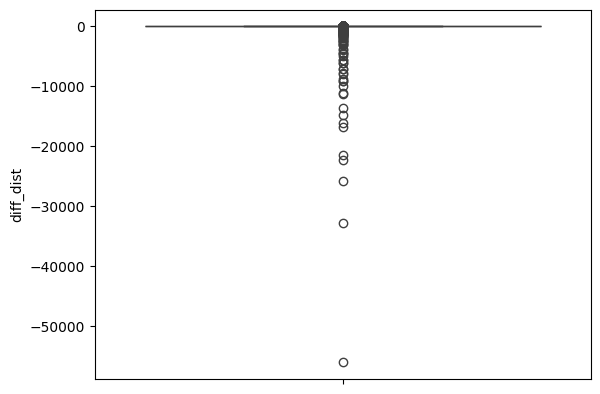

In [9]:
#посмотрим сколько значений сильно отклоняются от рассчетной "идальной" дистанции
temp = df.assign(ideal_dist=lambda x: (x['book_end_dttm']-x['book_start_dttm']).dt.total_seconds() *7/1000)[['order_rk','distance_km','book_end_dttm','book_start_dttm','ideal_dist']]\
    .assign(diff_dist = lambda x: x['ideal_dist']-x['distance_km'])\
    .query('diff_dist < 0')
# положительные отклонения любой величины нормальны, это значит,что пользователь проехал меньше,чем при идеальных условиях
# а вот отрицательные значения вызывают подозрения
sns.boxplot(temp.diff_dist)
plt.show()

#рассчет квантилей
Q1 = np.quantile(temp.diff_dist, 0.25) #Q1
Q3 = np.quantile(temp.diff_dist, 0.75)#Q3
IQR = Q3-Q1

# выбор id_поездок
temp = temp.order_rk.loc[temp.diff_dist < Q1-1.5*IQR]

Всего значений превышающие идеальный расчет 26140. Найдем все значения которые будут превосходить 1.5IQR (межквартильный интервал). Получим 2500 значений. 

In [10]:
print(f'Q1 {Q1}, Q3 {Q3}, IQR {IQR}')
temp.describe()

Q1 -0.9233352653753455, Q3 -0.172392818353711, IQR 0.7509424470216345


count    2.502000e+03
mean     2.852934e+08
std      3.417258e+07
min      2.526114e+08
25%      2.639951e+08
50%      2.704364e+08
75%      2.913808e+08
max      3.562520e+08
Name: order_rk, dtype: float64

Что с ними можно сделать? Ну, можно удалить их, объем данных позволяет нам избавится без существенного ущерба от 2500 значений. В тоже время, можно сказать, пусть ошибка в дистанции есть, но в остальных данных этих пользователей анамалий нет, поэтому можно дистанцию этих пользоватлей сделать равной средней скорости движения самокатов по пользователям * на то время, которое эти пользователи ехали. Сохраним данные, и избавимся от выбросов

In [11]:
#найдем среднюю скорость
temp_df = df.loc[~(df.order_rk.isin(temp))]
mean_time = ((temp_df.book_end_dttm - temp_df.book_start_dttm).dt.total_seconds()).mean()/3600 #в часах
mean_dist = (temp_df.distance_km).mean()
mean_velocity = mean_dist/mean_time
print(f'Среднее растояние {round(mean_dist,2)} км\nСреднее время езды {round(mean_time,2)}часа\nСредняя скорость {round(mean_velocity,2)}км/ч')


Среднее растояние 2.4 км
Среднее время езды 0.19часа
Средняя скорость 12.63км/ч


In [12]:
# отфильтруем данные и рассчитаем для них время в пути в часах
filtered_df = df.loc[(df.order_rk.isin(temp))]
filtered_df['time_hours'] = (filtered_df.book_end_dttm-filtered_df.book_start_dttm).dt.total_seconds()/3600

In [13]:
# рассчитаем расстояние
filtered_df.distance_km = filtered_df.time_hours * mean_velocity
#обновим данные в основной таблице
update_df = filtered_df[['order_rk','distance_km']]
update_df = df.merge(right=update_df, on='order_rk', how='left', suffixes=['','_update'])
df.distance_km = update_df.distance_km_update.fillna(df.distance_km)

#посмотрим на описание distance
df.distance_km.describe()

count    396749.000000
mean          2.408185
std           2.603710
min           0.000000
25%           0.939165
50%           1.723420
75%           3.035899
max          83.629171
Name: distance_km, dtype: float64

Видим еще одно выбивающиеся значение посмотрим его.
<br> Видим, что человек просто почти 6 часов катался на самокате и накатал такое расстояние,поэтому все окей

In [14]:
a = df.query('distance_km > 83').index
df.iloc[a].book_end_dttm-df.iloc[a].book_start_dttm

228088   0 days 05:42:31.271116
dtype: timedelta64[ns]

#### ---

#### аномалия в значениях кэшбэка

In [15]:
#loyalty_accrual_rub_amt
print('Количество значений с отрицательным значением кэшбэка ',df.query('loyalty_accrual_rub_amt < 0').shape[0])
df.query('loyalty_accrual_rub_amt < 0')

Количество значений с отрицательным значением кэшбэка  7


,order_rk,party_rk,gender_cd,age,education_level_cd,marital_status_cd,lvn_state_nm,minute_cost,activation_cost,hold_amount,transport_model,distance_km,created_dttm,book_start_dttm,book_end_dttm,book_time_zone_cd,local_book_start_dttm,nominal_price_rub_amt,loyalty_accrual_rub_amt,loyalty_accrual_bns_amt
133193,346866316,520065368,F,38,UGR,CIV,Г САНКТ-ПЕТЕРБУРГ,7.99,50.0,300.0,SL,2.962408,2024-09-17 19:21:36,2024-09-17 19:21:40.574000,2024-09-17 20:50:58.414000,3,2024-09-17 19:21:40.574000,769.10,-33.52,NaN
218430,350556979,1068354351,F,77,NaN,UNM,СВЕРДЛОВСКАЯ ОБЛ,6.49,30.0,300.0,E,0.287968,2024-09-30 13:18:30,2024-09-30 13:18:34.985000,2024-09-30 13:58:37.830000,5,2024-09-30 15:18:34.985000,296.09,-67.83,NaN
225743,263337728,544337483,M,22,NaN,NaN,Г МОСКВА,8.86,50.0,300.0,SL,13.229882,2024-07-28 15:43:29,2024-07-28 15:43:31.515713,2024-07-28 16:10:19.203000,3,2024-07-28 15:43:31.515713,289.22,-8.08,NaN
272310,348557969,904357431,M,18,GRD,UNM,КРАСНОЯРСКИЙ КРАЙ,6.49,0.0,300.0,SL,3.125962,2024-09-23 15:15:20,2024-09-23 15:15:26.060000,2024-09-23 16:07:48.379234,7,2024-09-23 19:15:26.060000,343.97,-65.29,NaN
297741,266324787,952764064,M,46,SCH,DIV,МОСКОВСКАЯ ОБЛ,6.99,50.0,300.0,SL,29.264670,2024-08-08 13:28:06,2024-08-08 13:28:10.899262,2024-08-08 16:52:01.011173,3,2024-08-08 13:28:10.899262,1475.96,-30.62,NaN
299220,351047641,759332373,M,27,GRD,UNM,Г САНКТ-ПЕТЕРБУРГ,7.99,50.0,300.0,SL,0.467784,2024-10-01 22:19:00,2024-10-01 22:19:05.461000,2024-10-01 22:22:58.094771,3,2024-10-01 22:19:05.461000,81.96,-5.00,NaN
340555,261319091,943073656,M,30,SCH,UNM,Г МОСКВА,8.39,50.0,300.0,SL,12.620194,2024-07-20 13:36:12,2024-07-20 13:36:16.909581,2024-07-20 17:11:41.426445,3,2024-07-20 13:36:16.909581,1862.24,-161.94,NaN


На счет кэшбэка идей нет, может сбой, а может действительно какие то акции позволяющие списать кэшбэк за поездку, нужно спрашивать у старших коллег
#### 
---

## Распределение пользователей 

### По возрастам и по полу

In [16]:
# Определение границ интервалов
bins = [0, 18, 25, 30, 35, 40, 45, 50, 55, 60, 100]

# Названия категорий
labels = ['18-', '18-24', '25-29', '30-34', '35-39', '40-44', '45-49', '50-54', '55-59', '60+']

# Создание новой колонки с возрастными группами
df['age_group'] = pd.cut(
                        df['age'],
                        bins=bins,
                        labels=labels,
                        right=False)  # Интервал включает левую границу


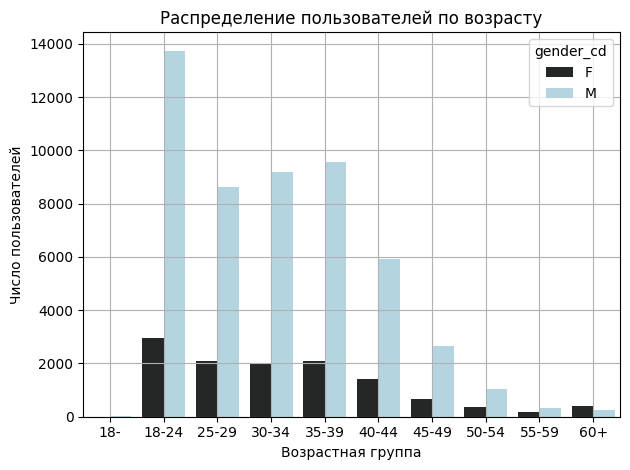

In [17]:
# распределение пользователей по возрасту
age_users = df.groupby(['age_group', 'gender_cd']).agg(user_cnt=('party_rk','nunique'))
age_users

sns.barplot(data=age_users, 
            x='age_group', 
            y='user_cnt', 
            color='lightblue',
            hue='gender_cd')
plt.grid()
plt.title('Распределение пользователей по возрасту')
plt.xlabel('Возрастная группа')
plt.ylabel('Число пользователей')
plt.tight_layout()
plt.show()

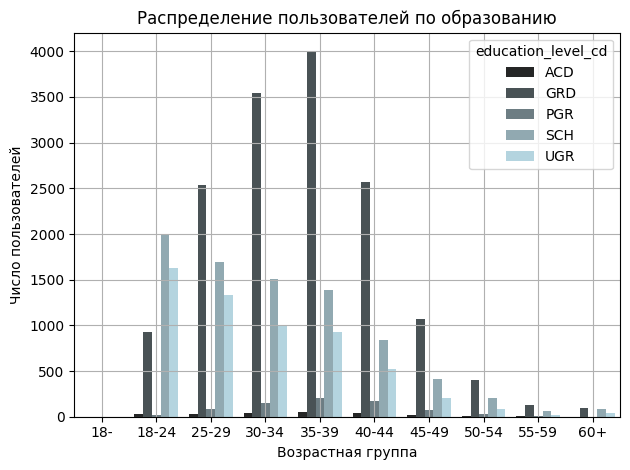

In [18]:
# распределение пользователей по образованию
age_users = df.groupby(['age_group', 'education_level_cd']).agg(user_cnt=('party_rk','nunique'))
age_users

sns.barplot(data=age_users, 
            x='age_group', 
            y='user_cnt', 
            color='lightblue',
            hue='education_level_cd')
plt.grid()
plt.title('Распределение пользователей по образованию')
plt.xlabel('Возрастная группа')
plt.ylabel('Число пользователей')
plt.tight_layout()
plt.show()

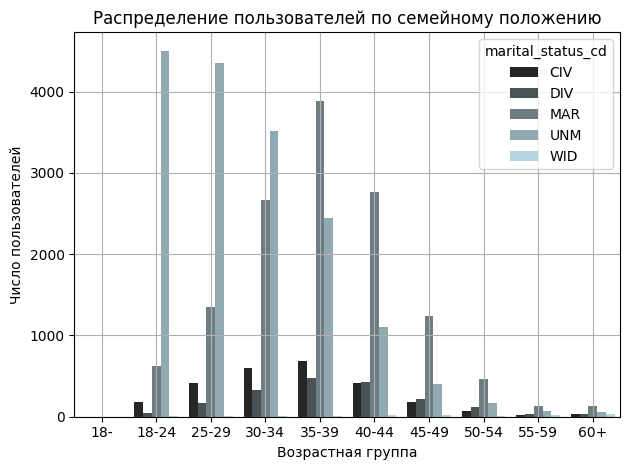

In [19]:
# распределение пользователей по семейному статусу 
age_users = df.groupby(['age_group', 'marital_status_cd']).agg(user_cnt=('party_rk','nunique'))
age_users

sns.barplot(data=age_users, 
            x='age_group', 
            y='user_cnt', 
            color='lightblue',
            hue='marital_status_cd')
plt.grid()
plt.title('Распределение пользователей по семейному положению')
plt.xlabel('Возрастная группа')
plt.ylabel('Число пользователей')
plt.tight_layout()
plt.show()

In [20]:
df.loc[df.age==94].duration_min.sum()

AttributeError: 'DataFrame' object has no attribute 'duration_min'

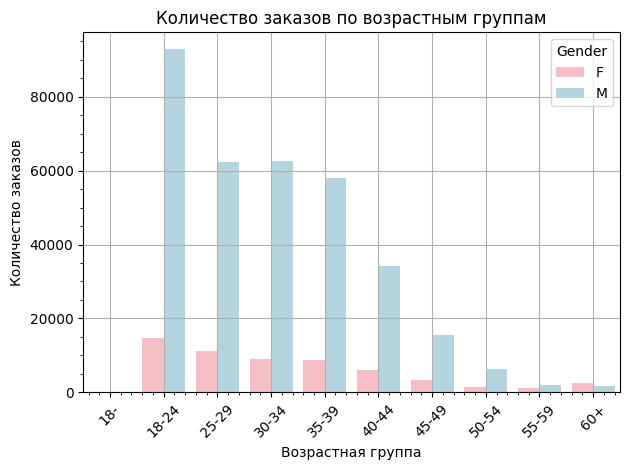

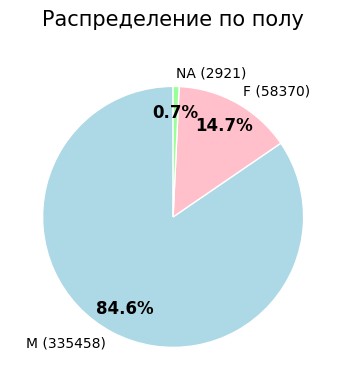

In [ ]:
df['duration_min'] = (df.book_end_dttm - df.book_start_dttm).dt.total_seconds()/60
age_grouped = df.groupby(['age_group','gender_cd'], as_index=False)\
                .agg(cnt_orders = ('order_rk','count'),
                     mean_time  = ('duration_min','mean'))\
                .sort_values(by='age_group')
sns.barplot(data = age_grouped, 
            x='age_group', 
            y='cnt_orders', 
            hue='gender_cd',
            palette={'M': 'lightblue', 'F': 'lightpink'})

plt.title("Количество заказов по возрастным группам")
plt.xlabel("Возрастная группа")
plt.ylabel("Количество заказов")
plt.xticks(rotation=45)
plt.minorticks_on()
plt.legend(title='Gender')
plt.grid()
plt.tight_layout()
plt.show()


counts = df.gender_cd.fillna('NA').value_counts()
labels = [f'{label} ({value})' 
         for label, value, percentage in 
         zip(counts.index, counts.values, counts / counts.sum() * 100)]

plt.figure(figsize=(4, 4))
patches, texts, autotexts = plt.pie(
    df.gender_cd.fillna('NA').value_counts(),
    labels=labels,
    colors=['lightblue', 'pink', '#99ff99'],
    startangle=90,
    autopct='%1.1f%%',
    pctdistance=0.8,
    wedgeprops={'edgecolor': 'white', 'linewidth': 1},
    textprops={'fontsize': 10}
)
plt.title('Распределение по полу', fontsize=15, pad=20)
plt.setp(autotexts, size=12, weight='bold')
plt.tight_layout()
plt.show()


Большие число заказов приходится на возрастную группу 18-24, что среди женщин, что среди мужчин

---

### по образованию

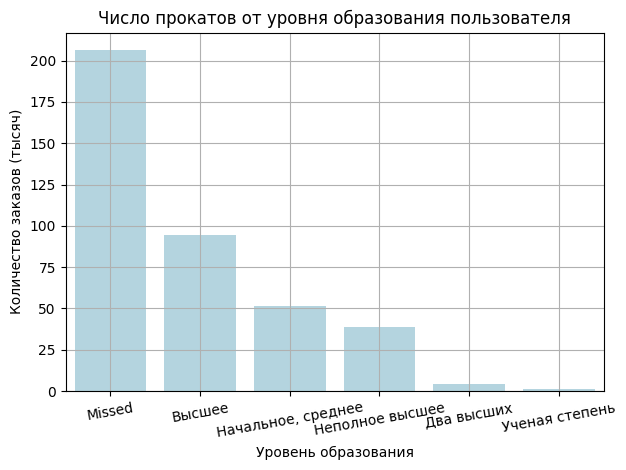

In [ ]:
#сделаем глубокую копию
educ_grouped=df.copy(deep=True)
educ_grouped.education_level_cd = educ_grouped.education_level_cd.fillna('Missed')

#переименуем для наглядности
educ_grouped.education_level_cd.loc[educ_grouped.education_level_cd=='GRD'] = 'Высшее'
educ_grouped.education_level_cd.loc[educ_grouped.education_level_cd=='SCH'] = 'Начальное, среднее'
educ_grouped.education_level_cd.loc[educ_grouped.education_level_cd=='UGR'] = 'Неполное высшее'
educ_grouped.education_level_cd.loc[educ_grouped.education_level_cd=='PGR'] = 'Два высших'
educ_grouped.education_level_cd.loc[educ_grouped.education_level_cd=='ACD'] = 'Ученая степень'

#группируем
educ_grouped = educ_grouped.groupby(['education_level_cd'], as_index = False)\
                           .agg(order_cnt = ('order_rk', 'count'))\
                           .sort_values(by='order_cnt', ascending=False)

#рисуем
sns.barplot(data = educ_grouped, 
            x ='education_level_cd', 
            y= educ_grouped.order_cnt/1000, color="lightblue")

plt.grid()
plt.title('Число прокатов от уровня образования пользователя')
plt.xlabel('Уровень образования')
plt.xticks(rotation=10)
plt.ylabel('Количество заказов (тысяч)')
plt.tight_layout()
plt.show()

---

### по семейному положению

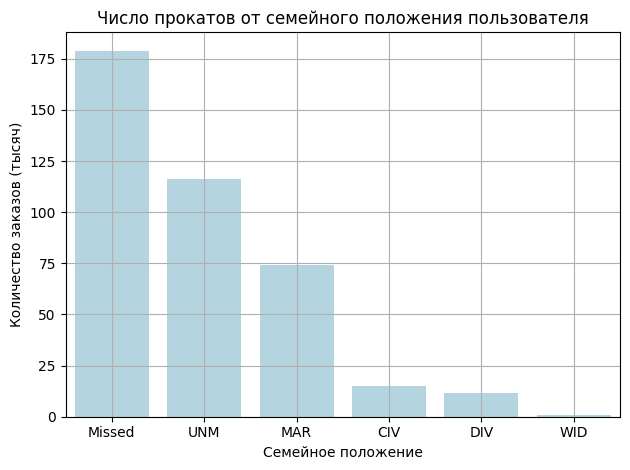

In [ ]:
marital = df.copy(deep=True)
marital.marital_status_cd = marital.marital_status_cd.fillna('Missed')
marital = marital.groupby(['marital_status_cd'], as_index=False)\
                 .agg(order_cnt = ('order_rk','count'))\
                 .sort_values(by='order_cnt', ascending=False)


sns.barplot(data = marital, 
            x ='marital_status_cd', 
            y= marital.order_cnt/1000, color="lightblue")
plt.grid()
plt.title('Число прокатов от семейного положения пользователя')
plt.xlabel('Семейное положение')
plt.ylabel('Количество заказов (тысяч)')
plt.tight_layout()
plt.show()

---

### По географии

Всего городов : 213


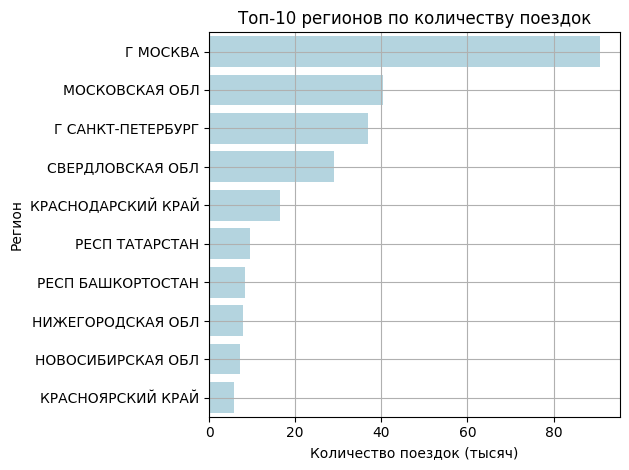

In [ ]:
print(f'Всего городов :',df.lvn_state_nm.unique().size)
# по географии
top_regions = df["lvn_state_nm"].value_counts().sort_values(ascending=False).nlargest(10)
sns.barplot(y=top_regions.index, x=top_regions.values/1000, color="lightblue")
plt.title("Топ-10 регионов по количеству поездок")
plt.xlabel("Количество поездок (тысяч)")
plt.ylabel("Регион")
plt.grid()
plt.tight_layout()
plt.show()

### распределение пользоватлей по модели самоката и их связь с возрастом и регионом

Далее расчеты будут сделаны для городов из топ 10  и для моделей самокатов из топ10 по числу аренд

Распределение заказов в топ регионах по возрастным группам

Text(0.5, 1.0, 'Заказы самокатов: возрастные группы и города')

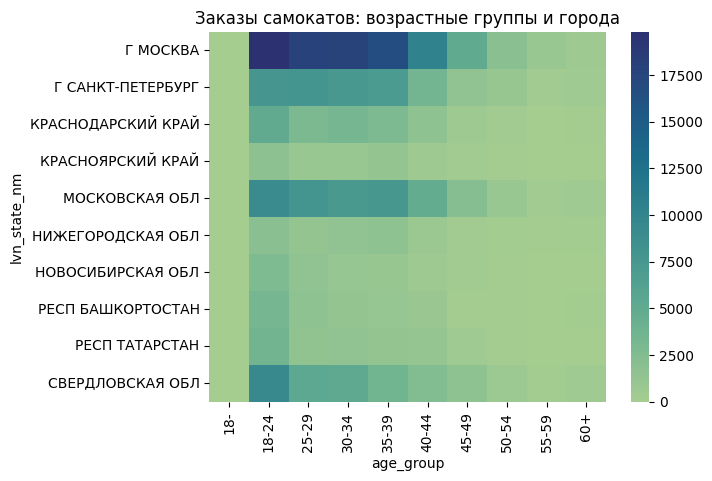

In [ ]:
age_region = df.loc[df.lvn_state_nm.isin(top_regions.index)]
age_region = age_region.groupby(['age_group','lvn_state_nm']).agg(order_cnt = ('order_rk','count')).reset_index()
age_region = age_region.pivot(index='lvn_state_nm', columns='age_group', values='order_cnt')
sns.heatmap(age_region, cmap ='crest')
plt.title('Заказы самокатов: возрастные группы и города')

Распределение заказов по топовым моделям самокатов и региона

Text(0.5, 1.0, 'Заказы самокатов: модели и города')

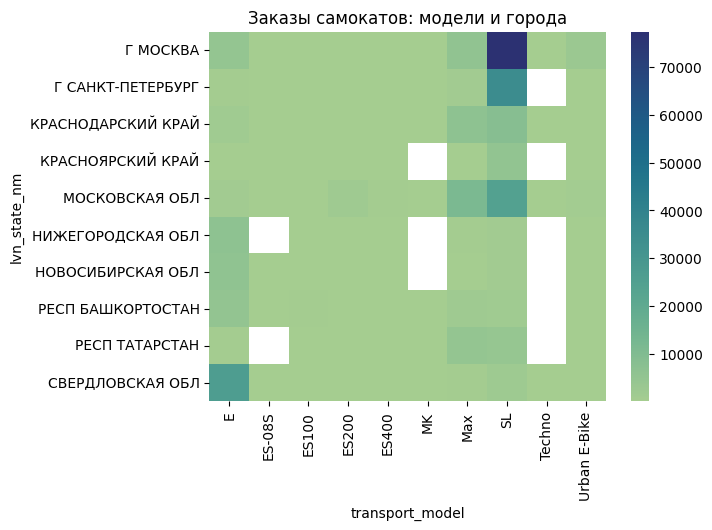

In [ ]:
#найдем топ моделей самокоов
top_model = df["transport_model"].value_counts().sort_values(ascending=False).nlargest(10)
model_region = df.loc[(df.transport_model.isin(top_model.index)) & (df.lvn_state_nm.isin(top_regions.index))]
model_region = model_region.groupby(['transport_model','lvn_state_nm']).agg(order_cnt = ('order_rk','count')).reset_index()

model_region = model_region.pivot(index='lvn_state_nm', columns='transport_model', values='order_cnt')
sns.heatmap(model_region, cmap ='crest')
plt.title('Заказы самокатов: модели и города')

Распределение заказов по топовым моделям самокатов и возрастных групп

Text(0.5, 1.0, 'Заказы самокатов: модели и возраста')

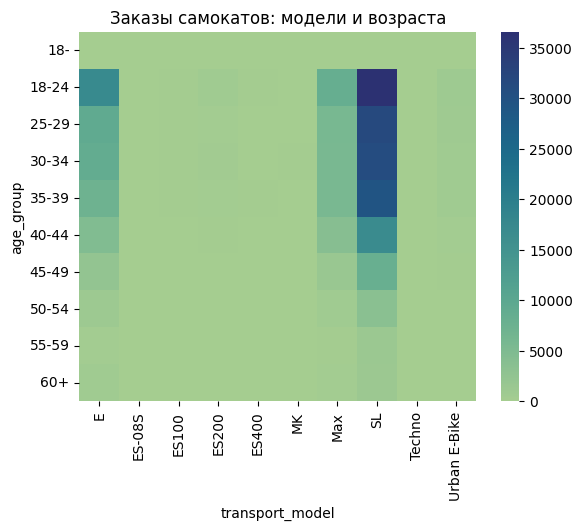

In [ ]:
age_model = df.loc[(df.transport_model.isin(top_model.index)) & (df.lvn_state_nm.isin(top_regions.index))]
age_model = age_model.groupby(['transport_model','age_group']).agg(order_cnt = ('order_rk','count')).reset_index()

age_model = age_model.pivot(index='age_group', columns='transport_model', values='order_cnt')
sns.heatmap(age_model, cmap ='crest')
plt.title('Заказы самокатов: модели и возраста')

Выводы:
- наиболее популярными моделями в Москве, МО и в Санкт-Петербурге является *SL*, в Свердловской области предпочитают модель *E*
- Наиболее часто берут самокаты модели *SL, MAX и E*


## Сезонное и времянное распределение прокатов

#### Распределение количества поездок в зависимости от месяца

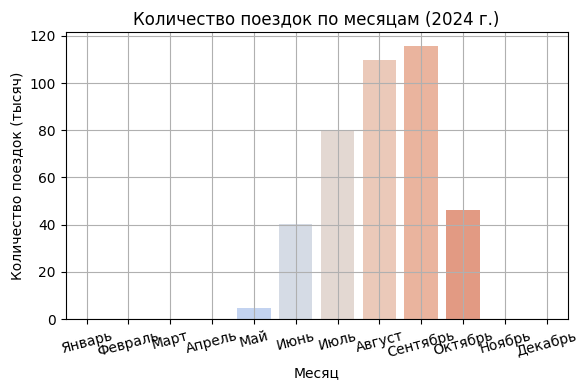

In [ ]:
#по месяцу
month_order = [
    'Январь', 'Февраль', 'Март', 'Апрель', 
    'Май', 'Июнь', 'Июль', 'Август', 
    'Сентябрь', 'Октябрь', 'Ноябрь', 'Декабрь']

monthly_counts = (
    df['created_dttm']
    .dt.month_name(locale='Russian')
    .astype(pd.CategoricalDtype(categories=month_order, ordered=True))).value_counts().sort_index()

plt.figure(figsize=(6,4))
sns.barplot(x=monthly_counts.index, y=monthly_counts.values/1000, palette="coolwarm")
plt.title("Количество поездок по месяцам (2024 г.)")
plt.xlabel("Месяц")
plt.xticks(rotation=15)
plt.ylabel("Количество поездок (тысяч)")
plt.grid()
plt.tight_layout()
plt.show()

---

#### Распределение количества поездок в зависимости от дня недели

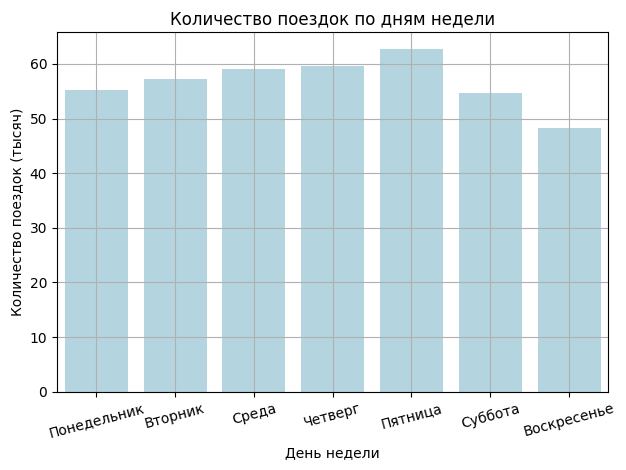

In [ ]:
weekday_map = {
    0: 'Понедельник',
    1: 'Вторник',
    2: 'Среда',
    3: 'Четверг',
    4: 'Пятница',
    5: 'Суббота',
    6: 'Воскресенье'}

week_day = df.copy(deep=True)
week_day['day_week'] = week_day.created_dttm.dt.weekday
week_day = week_day.groupby('day_week').agg(order_cnt = ('order_rk','count'))
week_day.rename(index=weekday_map, inplace=True)
week_day.reset_index(inplace=True)

sns.barplot(data=week_day, x="day_week", y=week_day.order_cnt/1000, color="lightblue")
plt.title("Количество поездок по дням недели")
plt.xlabel("День недели")
plt.grid()
plt.ylabel("Количество поездок (тысяч)")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

---

#### Распределение количества поездок в зависимости от времени суток

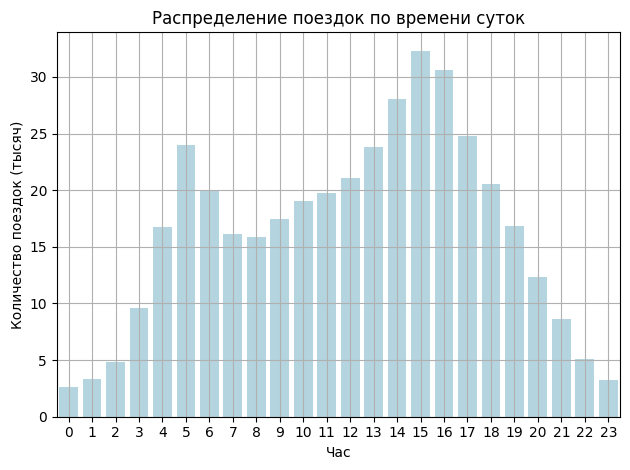

In [ ]:
# По времени суток
ride_hour = df.copy(deep=True)
ride_hour['hour'] = ride_hour.created_dttm.dt.hour
ride_hour = ride_hour.groupby('hour').agg(order_cnt = ('order_rk','count')).reset_index()

sns.barplot(data = ride_hour, x='hour', y= ride_hour.order_cnt/1000, color="lightblue")
plt.title("Распределение поездок по времени суток")
plt.xlabel("Час")
plt.ylabel("Количество поездок (тысяч)")
plt.grid()
plt.tight_layout()
plt.show()

А кто это катается так рано на самокате??? )))

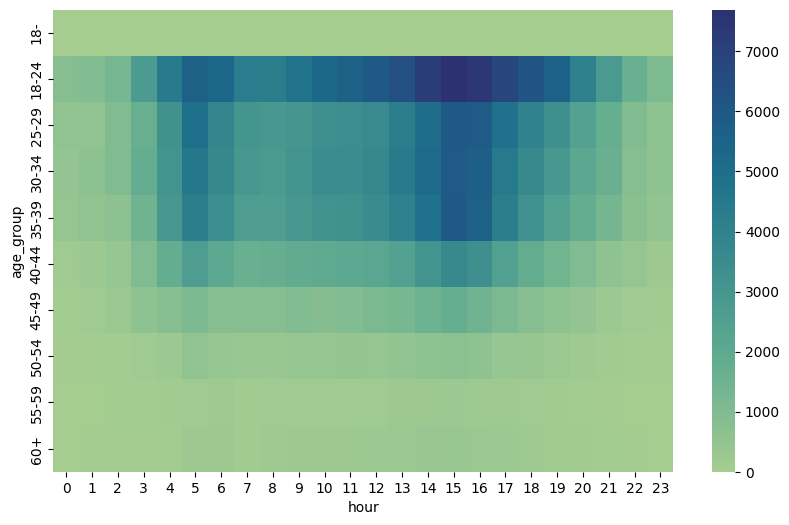

In [ ]:
plt.figure(figsize=(10,6))
ride_hour = df.copy(deep=True)
ride_hour['hour'] = ride_hour.created_dttm.dt.hour
ride_hour = ride_hour.groupby(['hour', 'age_group']).agg(order_cnt = ('order_rk','count')).reset_index()
ride_hour = ride_hour.pivot(columns='hour', index='age_group', values='order_cnt')
sns.heatmap(ride_hour, cmap='crest')
plt.xticks(rotation=0)
plt.show()

## Оценка расстояния

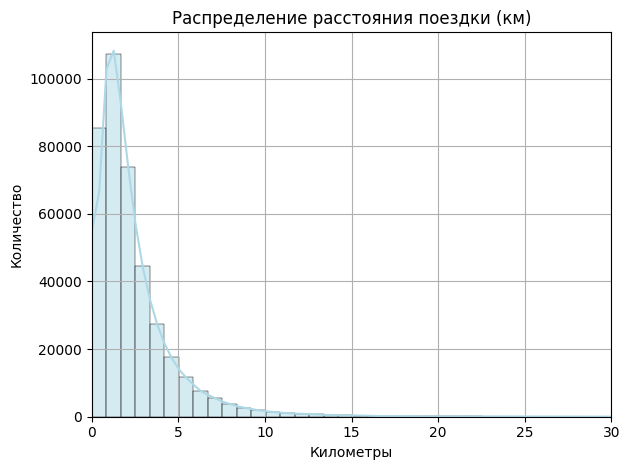

In [ ]:
# оценка среднего времени поездки
sns.histplot(df["distance_km"], bins=100, kde=True, color='lightblue')
plt.xlim(0, 30)
plt.title("Распределение расстояния поездки (км)")
plt.xlabel("Километры")
plt.ylabel("Количество")
plt.tight_layout()
plt.grid()
plt.tight_layout()
plt.show()

### Выводы
- распределение по месяцам года имеет максимум в сентября, после чего начинает резко падать. Нарастание спроса происходит с апреля по сентябрь.
- максимум заказов по дням недели растет к пятницы, после чего начинает падать, достигая минимального недельго размера в воскресенье
- распределение заказов по времени суток имеет два ярко выраженных максимума, один в районе 5 часов утра, второй в районе 15 часов дня

---

## Экономические показатели

### сколько было заработано средств

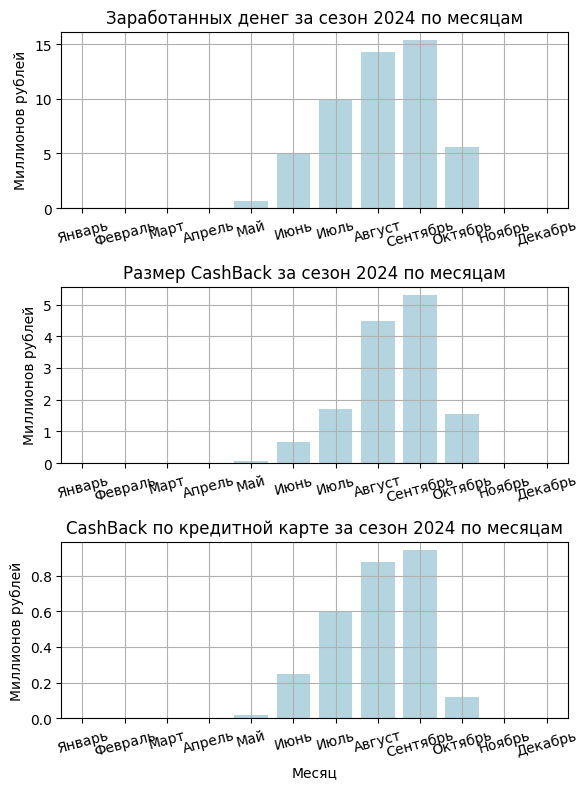

In [ ]:

earn_monthly = df.copy(deep=True)
earn_monthly['month']= (
    df['created_dttm']
    .dt.month_name(locale='Russian')
    .astype(pd.CategoricalDtype(categories=month_order, ordered=True)))

earn_monthly = earn_monthly.groupby(['month'], as_index=False)\
                           .agg(earn = ('nominal_price_rub_amt','sum'),
                                cashback=('loyalty_accrual_rub_amt', 'sum'),
                                cashback_credit = ('loyalty_accrual_bns_amt','sum'))

plt.figure(figsize=(6, 8)) 


plt.subplot(3, 1, 1)  
sns.barplot(data=earn_monthly, x='month', y=earn_monthly.earn/1e6, color='lightblue')
plt.title("Заработанных денег за сезон 2024 по месяцам")
plt.xlabel("")
plt.ylabel("Миллионов рублей")
plt.grid()
plt.xticks(rotation=15)


plt.subplot(3, 1, 2)
sns.barplot(data=earn_monthly, x='month', y=earn_monthly.cashback/1e6, color='lightblue')
plt.title("Размер CashBack за сезон 2024 по месяцам")
plt.xlabel("")
plt.ylabel("Миллионов рублей")
plt.grid()
plt.xticks(rotation=15)


plt.subplot(3, 1, 3)
sns.barplot(data=earn_monthly, x='month', y=earn_monthly.cashback_credit/1e6, color='lightblue')
plt.title("CashBack по кредитной карте за сезон 2024 по месяцам")
plt.xlabel("Месяц")
plt.ylabel("Миллионов рублей")
plt.grid()
plt.xticks(rotation=15)

plt.tight_layout()
plt.show()


In [ ]:
# сколько пользователей оплатили дебетовой картой
pay_debit = df.loc[df.loyalty_accrual_bns_amt.isna()]
print('Размер оплаченных средств с дебитовых карт ', round(pay_debit.nominal_price_rub_amt.sum()/1e6,2), ' миллионов рублей')
#оплата кредиткой
pay_credit = df.loc[~df.loyalty_accrual_bns_amt.isna()]
print('Размер оплаченных средств с кредитных карт ', round(pay_credit.nominal_price_rub_amt.sum()/1e6,2), ' миллионов рублей')

cashback_rub = df.loyalty_accrual_rub_amt.sum()
cashback_bns = df.loyalty_accrual_bns_amt.sum()
print(f'Размер выплаченных средств в качестве cashback: {round(cashback_rub/1e6,2)} миллионов рублей')
print(f'Размер выплаченных средств cashback в качестве бонусов :{round(cashback_bns/1e6,2)} миллионов рублей')

Размер оплаченных средств с дебитовых карт  47.69  миллионов рублей
Размер оплаченных средств с кредитных карт  2.95  миллионов рублей
Размер выплаченных средств в качестве cashback: 13.77 миллионов рублей
Размер выплаченных средств cashback в качестве бонусов :2.8 миллионов рублей


Выводы:
- графики полученной прибыли повторяют график проката самокатов в течении года в зависимости от месяца, что не удивительно.
- размер оплаченных средств с дебетовых карт: 47.69 , с кредитных карт: 2.94 миллионов рублей
- средства, вернувшиеся к клиентам по программе cashback 16.57 миллионов, из 2.8- в качестве бонусов и 13.77 размер средств в рублях

---

# Гипотезы

In [ ]:
df.head(1)

,order_rk,party_rk,gender_cd,age,education_level_cd,marital_status_cd,lvn_state_nm,minute_cost,activation_cost,hold_amount,...,created_dttm,book_start_dttm,book_end_dttm,book_time_zone_cd,local_book_start_dttm,nominal_price_rub_amt,loyalty_accrual_rub_amt,loyalty_accrual_bns_amt,age_group,duration_min
0,266071307,761067705,M,40,UGR,DIV,ТЮМЕНСКАЯ ОБЛ,4.99,30.0,300.0,...,2024-08-07 09:47:25,2024-08-07 09:47:29.325252,2024-08-07 10:07:59.339524,5,2024-08-07 11:47:29.325252,134.79,19.48,NaN,40-44,20.500238


**кэшбэк в виде бонусов на будущие поездки влияет больше на повторные прокаты, чем рублевый кэшбэк**

In [ ]:
bns_users = df.loc[~df.loyalty_accrual_bns_amt.isna()] #все записи у которых размер СВ <> NaN
rub_users = df.loc[~df.loyalty_accrual_rub_amt.isna()] #все записи у которых размер СВ <> NaN

In [ ]:
repeat_rate_bns = bns_users.groupby(['party_rk'], as_index = False).agg(order_cnt = ('order_rk','count')).sort_values(by='order_cnt')
bns_users_multiorder = repeat_rate_bns.party_rk.loc[repeat_rate_bns.order_cnt > 1].count()

In [ ]:
RR_bunos = bns_users_multiorder/repeat_rate_bns.party_rk.unique().size

In [ ]:
repeat_rate_rub = rub_users.groupby(['party_rk'], as_index = False).agg(order_cnt = ('order_rk','count')).sort_values(by='order_cnt')
rub_users_multiorder = repeat_rate_rub.party_rk.loc[repeat_rate_rub.order_cnt > 1].count()
rub_users_multiorder

RR_rub = rub_users_multiorder/repeat_rate_rub.party_rk.unique().size
RR_rub

np.float64(0.5889334587893494)

Сравним полученные значения повторного использования сервиса в зависимости от того, получал пользователь cashback в рублях или бонусах.

<br>H0: полученные значения repeat rate для двух выборок статистически значимо не отличаются 
<br>H1: полученные значения стат. значимо отличаются
- уровень значимости $\alpha $=0.05


In [ ]:
#сделаем таблицу сопряженности
tab = pd.DataFrame()
tab['rub_users'] = RR_rub, repeat_rate_rub.party_rk.unique().size
tab['bns_users'] = RR_bunos, repeat_rate_bns.party_rk.unique().size

p_value= st.chi2_contingency(tab)[1]
print(f'Оставляем H0 так как уровень значимости равен {round(p_value,2)}' if p_value>= 0.05 else f'Отклоняем нулевую гипотезу, так как уровень значимости равен {round(p_value,2)}')


Оставляем H0 так как уровень значимости равен 1.0
